# Using RNN/LSTM to predict Stock Prices

Long Short Term Memory(LSTM) Networks are a special type of Recurrent Neural Networks(RNN) which improves the learning of data based on the concept of short term memory. Based on the last 'n' values, predict the next value. 

In [1]:
import pandas as pd
import numpy as np

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

In [3]:
# install the nsepy library to get stock prices
#!pip install nsepy

In [4]:
# Getting Stock data using nsepy library
from nsepy import get_history
from datetime import datetime

startDate=datetime(2019, 1,1)
endDate=datetime(2020, 7, 20)

# Fetching the data
StockData=get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)
StockData.head()

(319, 14)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-01-01,INFY,EQ,658.95,660.95,666.3,654.15,665.95,665.05,660.66,2943390,1.944579e+14,45422,1282161,0.4356
2019-01-02,INFY,EQ,665.05,666.00,674.0,662.05,668.00,669.05,669.97,7416655,4.968963e+14,108094,3880800,0.5233
2019-01-03,INFY,EQ,669.05,672.00,677.0,663.10,668.00,669.15,669.66,6827249,4.571929e+14,125781,3676359,0.5385
2019-01-04,INFY,EQ,669.15,671.75,673.9,651.00,660.25,661.05,660.17,7889310,5.208305e+14,187590,3747741,0.4750
2019-01-07,INFY,EQ,661.05,665.00,673.6,661.50,671.70,671.70,667.51,8046340,5.370974e+14,132736,4711672,0.5856


In [5]:
# Creating a column as date
StockData['TradeDate']=StockData.index
StockData.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,TradeDate
Date,,,,,,,,,,,,,,,
2020-04-13,INFY,EQ,636.25,629.00,651.7,626.05,637.00,637.40,641.21,8330291,5.341426e+14,232090,3845112,0.4616,2020-04-13
2020-04-15,INFY,EQ,637.40,651.40,653.3,635.60,640.00,639.05,645.85,11963493,7.726657e+14,278339,7111564,0.5944,2020-04-15
2020-04-16,INFY,EQ,639.05,619.95,634.9,603.50,626.90,623.85,620.50,17783310,1.103451e+15,254606,9056129,0.5092,2020-04-16
2020-04-17,INFY,EQ,623.85,644.00,646.0,626.00,634.20,628.75,633.50,8878372,5.624423e+14,220448,4596958,0.5178,2020-04-17
2020-04-20,INFY,EQ,628.75,640.00,661.0,639.00,650.95,653.30,653.71,13322995,8.709345e+14,220363,4044244,0.3036,2020-04-20


### Plotting the closing  prices of stock

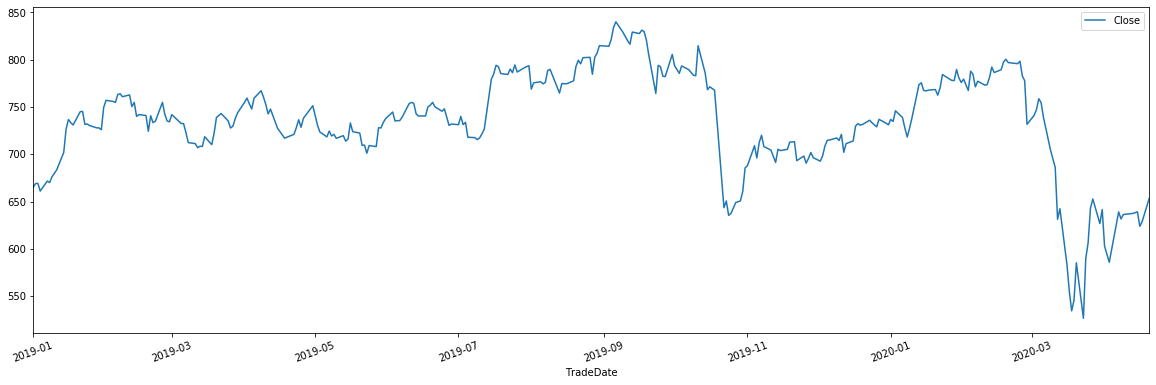

In [6]:
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

### Preparing the data

In [7]:
FullData=StockData[['Close']].values
FullData[0:5]

array([[665.05],
       [669.05],
       [669.15],
       [661.05],
       [671.7 ]])

### Feature Scaling for fast training

In [8]:
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

X[0:5]

array([[0.4418234 ],
       [0.45457443],
       [0.45489321],
       [0.42907236],
       [0.463022  ]])

In [9]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [10]:
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
X_data.shape

(309, 10, 1)

In [11]:
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
y_data.shape

(309, 1)

In [12]:
# Choosing the number of testing data records
TestingRecords=10

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [13]:
# Printing the shape of training and testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(299, 10, 1)
(299, 1)
(10, 10, 1)
(10, 1)


In [14]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:5], y_train[0:5]):
    print(inp,'-->', out)

[[0.4418234 ]
 [0.45457443]
 [0.45489321]
 [0.42907236]
 [0.463022  ]
 [0.45776219]
 [0.47704814]
 [0.48852407]
 [0.50063755]
 [0.55929232]] --> [0.63802996]
[[0.45457443]
 [0.45489321]
 [0.42907236]
 [0.463022  ]
 [0.45776219]
 [0.47704814]
 [0.48852407]
 [0.50063755]
 [0.55929232]
 [0.63802996]] --> [0.67054511]
[[0.45489321]
 [0.42907236]
 [0.463022  ]
 [0.45776219]
 [0.47704814]
 [0.48852407]
 [0.50063755]
 [0.55929232]
 [0.63802996]
 [0.67054511]] --> [0.65954734]
[[0.42907236]
 [0.463022  ]
 [0.45776219]
 [0.47704814]
 [0.48852407]
 [0.50063755]
 [0.55929232]
 [0.63802996]
 [0.67054511]
 [0.65954734]] --> [0.65189672]
[[0.463022  ]
 [0.45776219]
 [0.47704814]
 [0.48852407]
 [0.50063755]
 [0.55929232]
 [0.63802996]
 [0.67054511]
 [0.65954734]
 [0.65189672]] --> [0.69668473]


In [15]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


### Fitting the Deep Learning LSTM model

In [18]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0084
Epoch 2/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0082
Epoch 3/100
299/299 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 4/100
299/299 [==============================] - 2s 5ms/step - loss: 0.0079
Epoch 5/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0071
Epoch 6/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 7/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 8/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0061
Epoch 9/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0062
Epoch 10/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0063
Epoch 11/100
299/299 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 12/100
299/299 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 13/100


### Generating predictions on testing data

In [21]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[661.3167 ],
       [652.0507 ],
       [635.09375],
       [644.3854 ],
       [651.93976],
       [658.9933 ],
       [662.9178 ],
       [665.9012 ],
       [659.83936],
       [657.39136]], dtype=float32)

In [22]:
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
orig

array([[602.8 ],
       [585.7 ],
       [639.  ],
       [631.6 ],
       [636.25],
       [637.4 ],
       [639.05],
       [623.85],
       [628.75],
       [653.3 ]])

### Measuring the Accuracy of predictions

In [23]:
# Accuracy of the predictions
100 - (100*(abs(orig-predicted_Price)/orig)).mean()

95.44284236619102

### Plotting the predictions for Testing data

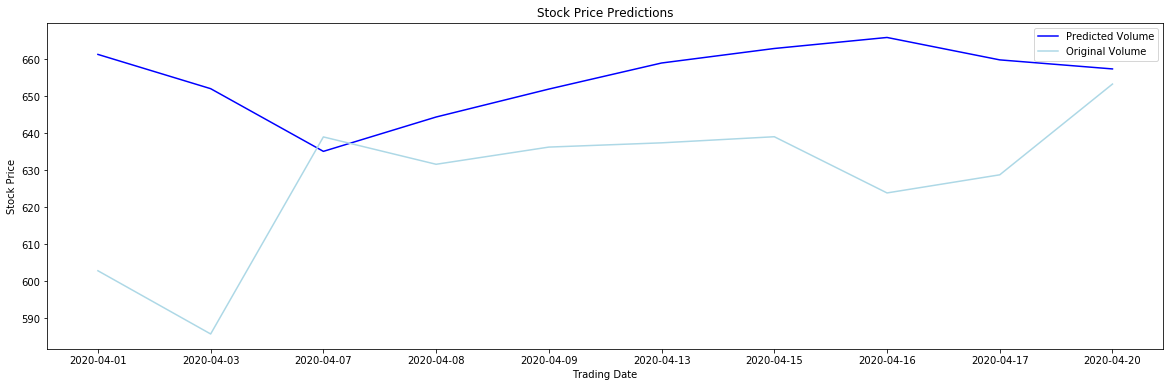

In [24]:
# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

### Plotting the predictions for full data

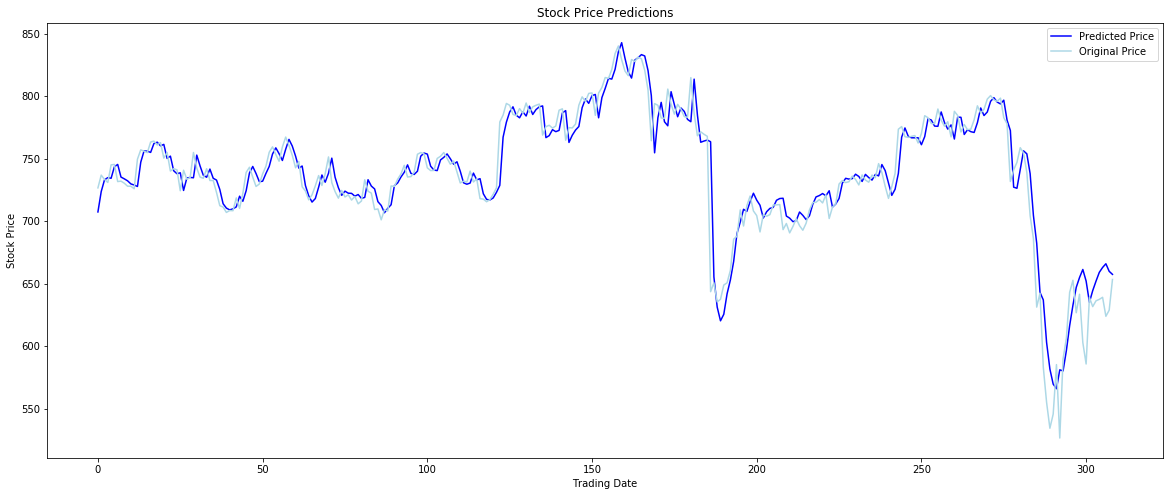

In [25]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()